In this notebook, we plot the basin of attractions for 2D ORGaNICs.

In [ ]:
"""We define the class for simulating the ORGaNICs model."""
import torch
import matplotlib.pyplot as plt
import time
import math
from models.utils.sim_spectrum import sim_solution
import models.ORGaNICs_models as organics
import numpy as np
import os
from matplotlib import colors
from scipy.optimize import fsolve
import warnings


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
cmap = 'viridis'

### Fixed point for the high-dimensional ORGaNICs circuit

In [2]:
"""Define the parameters of the model"""
N = 5
params = {
    'N_y': N,
    'N_a': N,
    'eta': 0.001,
    'noise_type': 'additive'
}
b0 = 0.4 * torch.ones(N)
b1 = 0.5 * torch.ones(N)
sigma = 0.1
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
Wyy = torch.eye(N)
Way = torch.rand(N, N)

# Define the input drive
z = torch.randn(N)

In [3]:
model = organics.ORGaNICs2Dgeneral(params=params, b0=b0, b1=b1, sigma=sigma, tauA=tauA, tauY=tauY, Wyy=Wyy, Way=Way, z=z, run_jacobian=True)

In [4]:
# Simulation fixed points
y_sim = model.ss[0:N]
a_sim = model.ss[N:2 * N]

In [5]:
# Analystical fixed points
a_analytical = b0 ** 2 * sigma ** 2 + Way @ ((b1 * z) ** 2)
y_analytical = b1 * z / torch.sqrt(a_analytical)

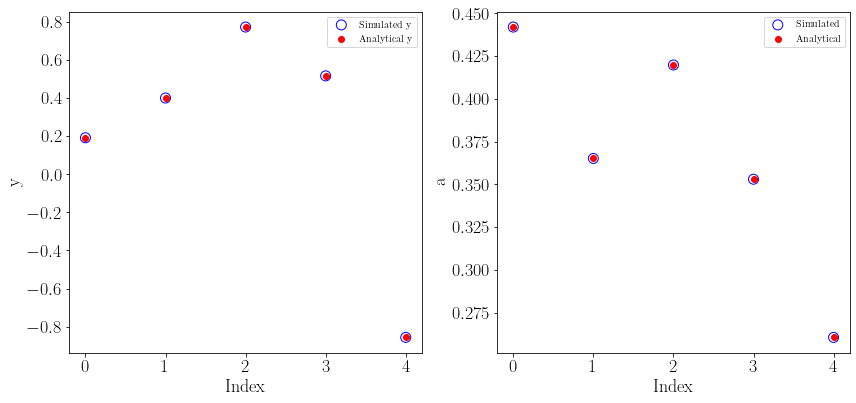

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Create 1 row, 2 columns of subplots

# Plot for y values
ax1.scatter(range(len(y_sim)), y_sim, edgecolors='blue', facecolors='none', label='Simulated y', s=100)
ax1.scatter(range(len(y_analytical)), y_analytical, color='red', label='Analytical y')
ax1.set_xlabel('Index', fontsize=18)
ax1.set_ylabel('y', fontsize=18)
ax1.legend()
ax1.tick_params(axis='both', which='major', labelsize=18)

# Plot for a values
ax2.scatter(range(len(a_sim)), a_sim, edgecolors='blue', facecolors='none', label='Simulated', s=100)
ax2.scatter(range(len(a_analytical)), a_analytical, color='red', label='Analytical')
ax2.set_xlabel('Index', fontsize=18)
ax2.set_ylabel('a', fontsize=18)
ax2.legend()
ax2.tick_params(axis='both', which='major', labelsize=18)

# Adjust overall figure settings

# Remove individual subplot titles and adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()  # Display the plot

### Analysis of the the two-dimensional model

In [104]:
"""Define the parameters of the model"""
N = 1
params = {
    'N_y': N,
    'N_a': N,
    'eta': 0.001,
    'noise_type': 'additive'
}
# b0 = 1.0 * torch.ones(N)
b0 = 0.5 * torch.ones(N)
b1 = 0.5 * torch.ones(N)
# sigma = 1.0
sigma = 0.1
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
# Wyy = torch.tensor([[2.0]])
Wyy = torch.tensor([[0.5]])
Way = torch.tensor([[1.0]])

# Define the input drive
z = torch.tensor([1.0])

In [105]:
"""Define the model"""
model = organics.ORGaNICs2Dgeneral(params=params, b0=b0, b1=b1, sigma=sigma, tauA=tauA, tauY=tauY, Wyy=Wyy, Way=Way, z=z, run_jacobian=False)

Find the fixed point of the system.

In [106]:
# We define the gradients for a given location
def fixed_point_func(variables):
    y, a = variables
    x = torch.tensor((y, a))
    grad = model._dynamical_fun(0, x)
    return [grad[0], grad[1]]

In [107]:
# We solve the equivalent quartic equation, valid when 0 < w_r < 1
a = Wyy ** 2
b = 2 * (1 - Wyy) * Wyy
c = (1 - Wyy) ** 2 - Way * (b1 * z) ** 2 - b0 ** 2 * sigma ** 2 * Wyy ** 2
d = - 2 * (1 - Wyy) * Wyy * b0 ** 2 * sigma ** 2
e = - (1 - Wyy) ** 2 * b0 ** 2 * sigma ** 2

In [108]:
a_prime = Wyy ** 2
b_prime = - 2 * (1 - Wyy) * Wyy
c_prime = (1 - Wyy) ** 2 - Way * torch.relu(b1 * z) ** 2 - b0 ** 2 * sigma ** 2 * Wyy ** 2
d_prime = 2 * Way * torch.relu(b1 * z) ** 2 * (1 - Wyy) / Wyy
e_prime = - (1 - Wyy) ** 2 * torch.relu(b1 * z) ** 2 * Way / Wyy ** 2

In [109]:
coefficients = [a.item(), b.item(), c.item(), d.item(), e.item()]

print("Coefficients:", coefficients)
sqrt_a_roots = np.roots(coefficients)
print("Roots:", sqrt_a_roots)

Coefficients: [0.25, 0.5, -0.0006250000000000001, -0.0012500000000000002, -0.0006250000000000001]
Roots: [-2.00031255+0.j          0.11362209+0.j         -0.05665477+0.08826041j
 -0.05665477-0.08826041j]


In [110]:
coefficients_prime = [a_prime.item(), b_prime.item(), c_prime.item(), d_prime.item(), e_prime.item()]
print("Coefficients prime:", coefficients_prime)
roots_prime = np.roots(coefficients_prime)
print("Roots prime:", torch.tensor(roots_prime) + (Wyy - 1) / Wyy)

Coefficients prime: [0.25, -0.5, 0.249375, 0.0, -0.0]
Roots prime: tensor([[ 0.0500, -0.0500, -1.0000, -1.0000]])


In [111]:
fixed_points = []
stability = []
jacobians = []
eigs = []

for root in sqrt_a_roots:
    # check if real and positive
    if abs(np.imag(root)) < 1e-10 and np.real(root) > 0:
        a_s = np.real(root) ** 2
        y_s = (b1 * z / (1 - Wyy + Wyy * np.real(root))).numpy().item()
        fixed_points.append([y_s, a_s])
        # calculate the jacobian at the given fixed point
        J, _ = model.jacobian_autograd(ss=torch.tensor([y_s, a_s]))
        jacobians.append(J)
        eigs.append(torch.linalg.eigvals(J))
        # check real parts of eigenvalues and determine stability
        if torch.all(torch.real(torch.linalg.eigvals(J)) < 0):
            stability.append("stable")
        else:
            stability.append("unstable")

# print the fixed points and stability
print("Fixed points:", fixed_points)
print("Stability:", stability)
print("Eigenvalues:", eigs)

Fixed points: [[-0.8979706913928603, 0.012909979814850953]]
Stability: ['stable']
Eigenvalues: [tensor([-187.6149+56.6523j, -187.6149-56.6523j])]


In [112]:
b0 * sigma - (1 - 1 / Wyy)

tensor([[1.0500]])

Find the phase portrait of the system.

In [113]:
# We define the gradients for a given location
def organics_gradient(y, a):
    x = torch.tensor((y, a))
    grad = model._dynamical_fun(0, x)
    return grad[0], grad[1]

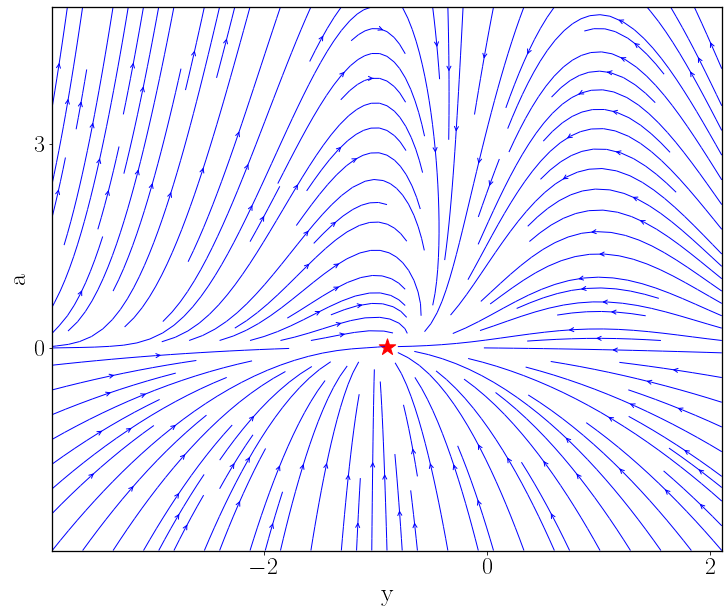

In [ ]:
# Find the center point
for idx, fixed_point in enumerate(fixed_points):
    if stability[idx] == "stable":
        centre_point = fixed_point

right = 3
up = 5
down = 3
left = 3
points = 100j

a, y = np.mgrid[centre_point[1]-down:centre_point[1]+up:points, centre_point[0]-left:centre_point[0]+right:points]

# run a for loop to get the gradients
u = np.zeros_like(y)
v = np.zeros_like(a)
for i in range(y.shape[0]):
    for j in range(a.shape[1]):
        u[i, j], v[i, j] = organics_gradient(y[i, j], a[i, j])  # Assuming you have a function named organics_gradient

plt.figure(figsize=(12, 10))  # Adjusted figure size

# Create the stream plot
plt.streamplot(y, a, u, v, color='blue', linewidth=1, density=1.5, arrowstyle='->')

# Plot the fixed points
for idx, fixed_point in enumerate(fixed_points):
    if stability[idx] == "stable":
        plt.scatter(fixed_point[0], fixed_point[1], color='red', marker='*', s=300)
    else:
        plt.scatter(fixed_point[0], fixed_point[1], color='black', marker='*', s=300)

# Customizing the plot
plt.xlabel('y', fontsize=26)
plt.ylabel('a', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Make the border thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.3)  # Set the desired thickness here

# Reduce the number of ticks
# Reduce the number of ticks to only show integers
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(3, integer=True))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(3, integer=True))



# Save the figure
# file_name = 'unrectified/z_positive_wr_smaller_1.svg'
file_name = 'unrectified/z_negative_wr_smaller_1.svg'
file_path = '../../figures/' + file_name
plt.savefig(file_path, bbox_inches='tight', format='svg', dpi=500)

# Showing the plot
plt.show()